In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## AR모형

In [80]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

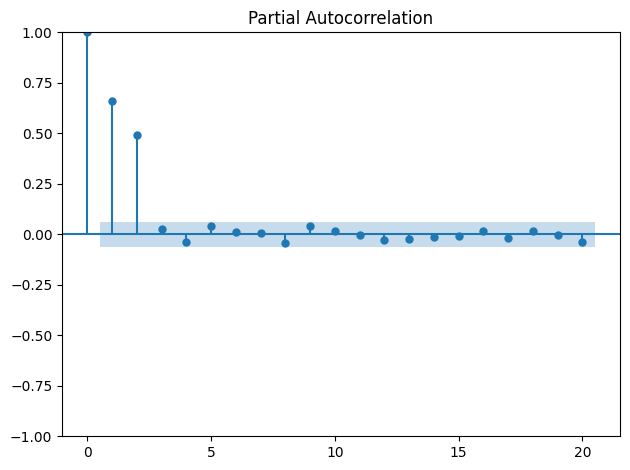

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20);
plt.tight_layout()
plt.show()

- 함수를 하나씩 살펴봐야 하는 함수
    - 롤링 함수(rolling_forecast())함수임.
    - 3차 프로젝트 때 ML모형을 만드다면 응용이 필수적임.

In [82]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/iM_alphaco/시계열 강의안(통계, ML, DL)/data/'

df = pd.read_csv(DATA_PATH + 'foot_traffic.csv')
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


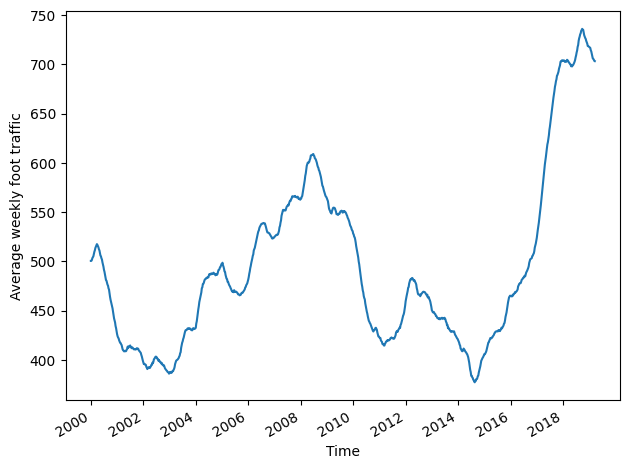

In [83]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 차분 및 정상성 확인

In [84]:
def difference_and_check(data_tmp, max_diff=5):
    """
    시계열 데이터가 정상적이지 않으면 차분하여 정상성 검정을 반복 수행하고
    ACF 도식화를 생성하는 함수.

    :param data: 시계열 데이터
    :param max_diff: 최대 차분 횟수
    :return: 차분 후 데이터 및 차분 횟수
    """
    diff_count = 0

    while diff_count < max_diff:
        # ADF 검정
        ADF_result = adfuller(data_tmp)
        p_value = ADF_result[1]

        print(f'차분 {diff_count}회 - ADF 통계량: {ADF_result[0]}, p-값: {p_value}')

        if p_value < 0.05:  # p-value가 0.05 미만이면 정상성을 만족
            print(f"차분 {diff_count}회: 데이터가 정상성을 만족합니다.")
            break

        # 차분 수행
        print(f"차분 {diff_count}회: 정상성 미만, 차분 후 다시 ADF 검정 수행")
        diff_count += 1
        data_tmp = data_tmp.diff().dropna()  # 한 번 차분

    # ACF 도식화
    plot_acf(data_tmp)
    plt.title(f'ACF after {diff_count} differencing')
    plt.show()

    return data_tmp, diff_count

차분 0회 - ADF 통계량: -1.1758885999240747, p-값: 0.683880891789619
차분 0회: 정상성 미만, 차분 후 다시 ADF 검정 수행
차분 1회 - ADF 통계량: -5.268231347422044, p-값: 6.369317654781239e-06
차분 1회: 데이터가 정상성을 만족합니다.


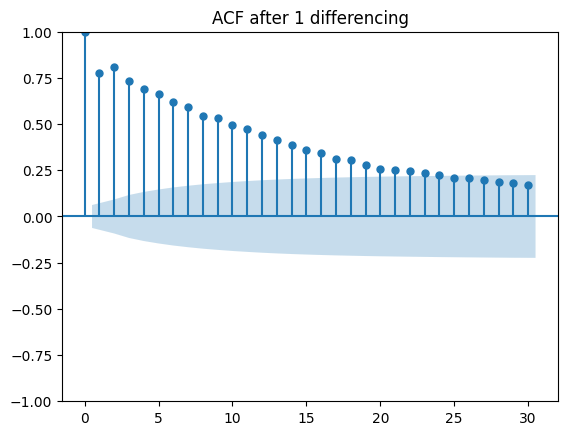

(     foot_traffic
 1        0.025651
 2        0.904511
 3        1.869114
 4        0.836705
 5        1.039848
 ..            ...
 995     -2.343634
 996     -0.398483
 997     -0.839213
 998     -1.211415
 999     -0.274685
 
 [999 rows x 1 columns],
 1)

In [85]:
difference_and_check(df)

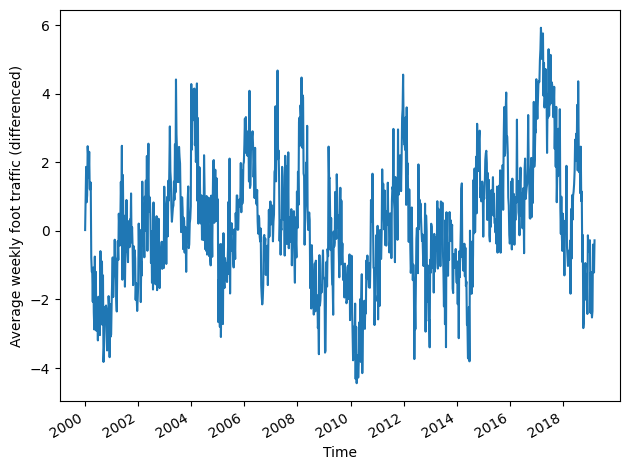

In [86]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

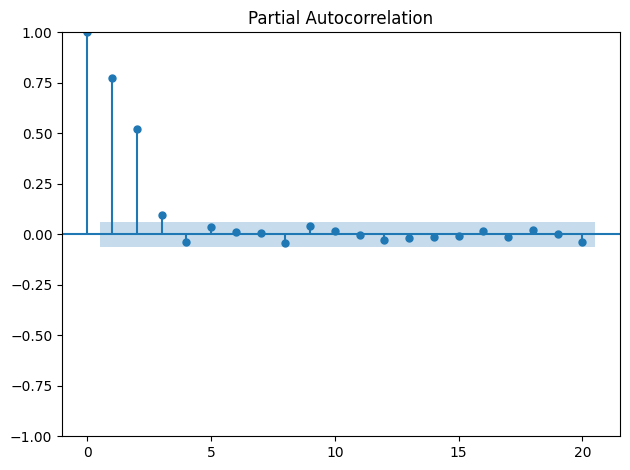

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(foot_traffic_diff, lags = 20)
plt.tight_layout()
plt.show()

## 자기회귀과정 예측

- 지난 훈련데이터, 테스트 데이터 만들기
- 지난 52주간의 데이터를 기준점으로, 훈련/테스트 데이터 분리

In [88]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
df_diff.head(1)

,foot_traffic_diff
0,0.025651


In [89]:
train = df_diff[:-52]
test = df_diff[-52:]

len(train), len(test)

(947, 52)

### 세 가지 기법 사용

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    """
    롤링 윈도우 방법으로 시계열 데이터를 예측하는 함수.

    매개변수:
    - df (pd.DataFrame): 입력 시계열 데이터.
    - train_len (int): 학습 데이터의 길이 (초기 학습 구간 크기).
    - horizon (int): 예측할 데이터의 기간 (총 예측 기간).
    - window (int): 롤링 윈도우 크기.
    - method (str): 예측 방법 ('mean', 'last', 'MA' 중 하나 선택).

    반환값:
    - list: 예측된 값의 리스트.
    """

    # 학습 기간과 예측 기간을 합친 전체 길이
    total_len = train_len + horizon

    # 'mean' 방법: 이전 데이터의 평균값을 예측 값으로 사용
    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # 현재 윈도우 이전까지의 평균 계산
            mean = np.mean(df[:i].values)
            # 계산된 평균값을 현재 윈도우 크기만큼 예측값 리스트에 추가
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    # 'last' 방법: 이전 데이터의 마지막 값을 예측 값으로 사용
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # 현재 윈도우 이전까지의 마지막 값 가져오기
            last_value = df[:i].iloc[-1].values[0]
            # 가져온 마지막 값을 현재 윈도우 크기만큼 예측값 리스트에 추가
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    # 'MA' 방법: 이동평균(MA) 모델을 사용해 예측
    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # SARIMAX 모델 설정: (0,0,2)은 MA(2) 모델을 의미
            model = SARIMAX(df[:i], order=(0, 0, 2))
            # SARIMAX 모델 학습
            res = model.fit(disp=False)
            # 학습된 모델로 예측 수행
            predictions = res.get_prediction(0, i + window - 1)
            # 예측값 중 마지막 윈도우에 해당하는 값들 가져오기
            oos_pred = predictions.predicted_mean.iloc[-window:]
            # 예측값을 결과 리스트에 추가
            pred_MA.extend(oos_pred)

        return pred_MA

In [91]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_MA'] = pred_MA

test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_MA
947,-0.776601,0.213270,-1.021893,-0.768028
948,-0.574631,0.212226,-0.776601,0.081580
949,-0.890697,0.211397,-0.574631,-0.284657
950,-0.283552,0.210237,-0.890697,-0.614989
951,-1.830685,0.209717,-0.283552,-0.187290


# ARIMA_ARIMA
- 온천 아님

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [93]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042695
p-value: 1.707846668009654e-08


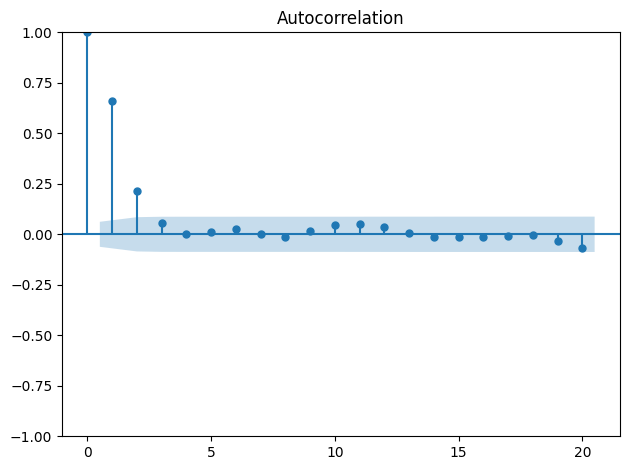

In [94]:
plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

### AIC 활용

In [95]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [96]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list): # p와 q를 가지고 있는 후보군
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [97]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.162939
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


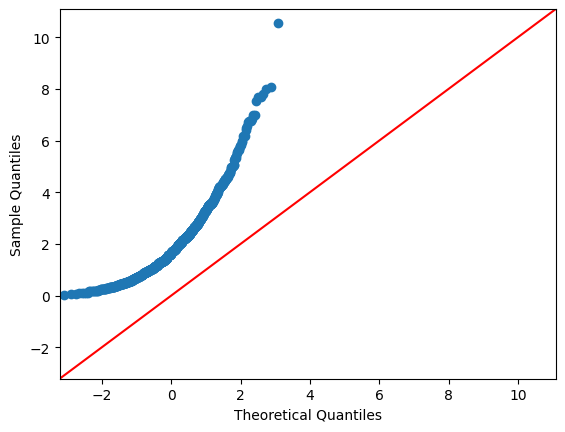

In [98]:
## 잔차분석
# 정상적 분석

from statsmodels.graphics.gofplots import qqplot

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

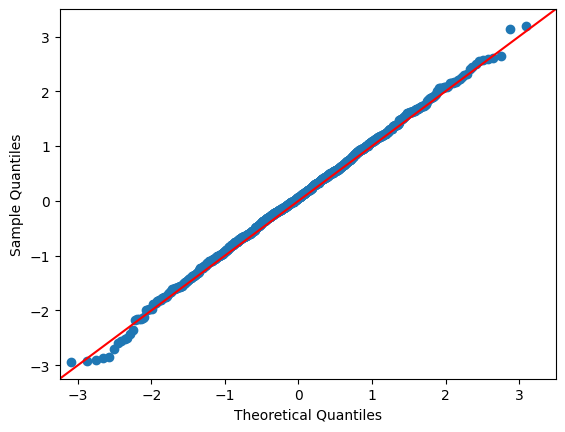

In [99]:
normal = np.random.normal(size=1000)

qqplot(normal, line='45');

# 잔차 분석 수행
- 여전히 시뮬레이션 데이터인걸 잊지 말것!

In [100]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

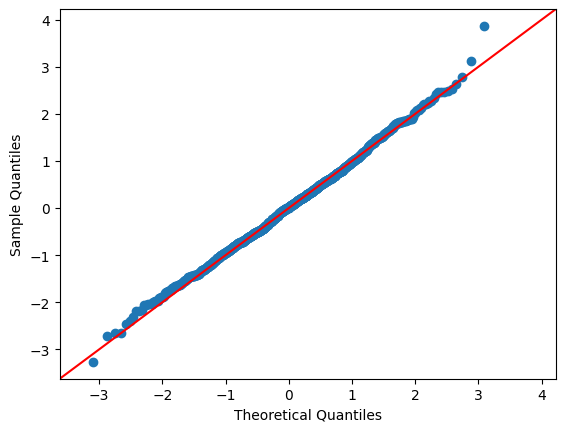

In [101]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

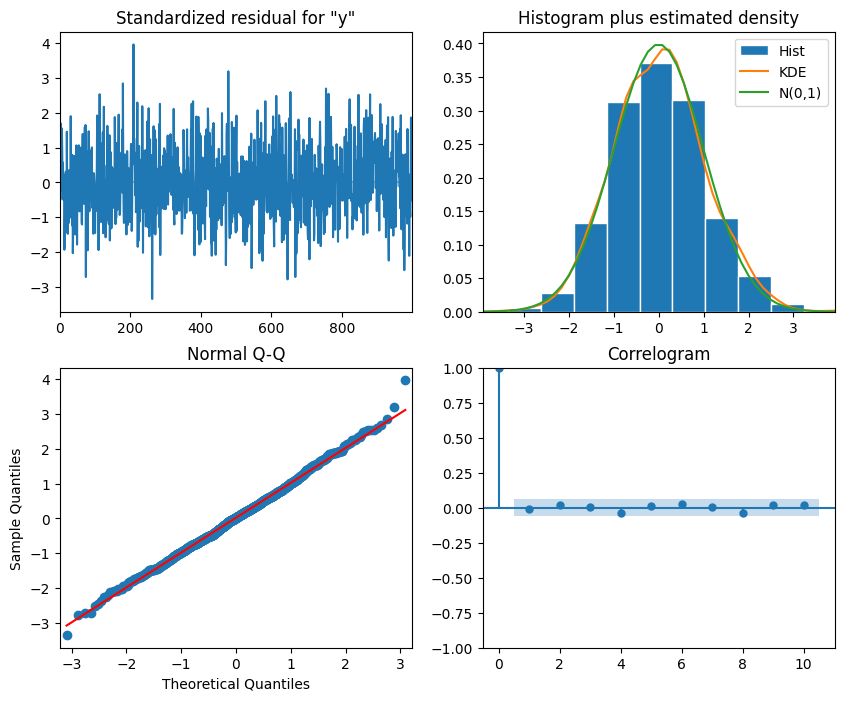

In [102]:
model_fit.plot_diagnostics(figsize=(10, 8));

## 실전데이터 적용
- 존슨앤존슨 데이터 적용
- 맨 처음에 했던 데이터로 -> 성능은 더 좋을 것으로 기대됨

In [103]:
# 향후 2시간의 전기 사용량을 분석하는 데이터

df = pd.read_csv(DATA_PATH + 'bandwidth.csv')
df.head()


,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


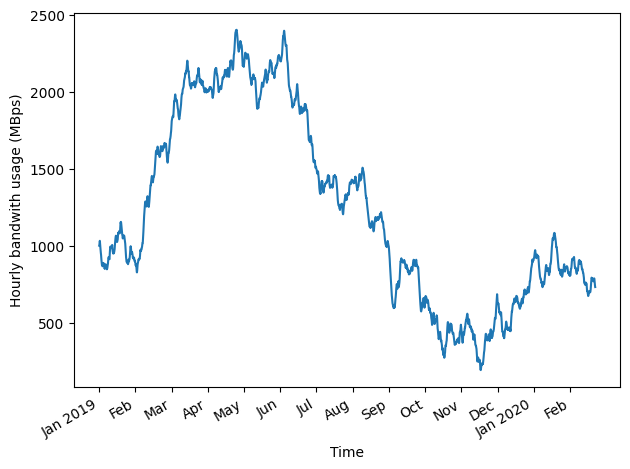

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## ADF테스트
- 대립가설 만족 시 시계열 정상적

In [105]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8714653199452735
p-value: 0.7972240255014551


- 차분 실행

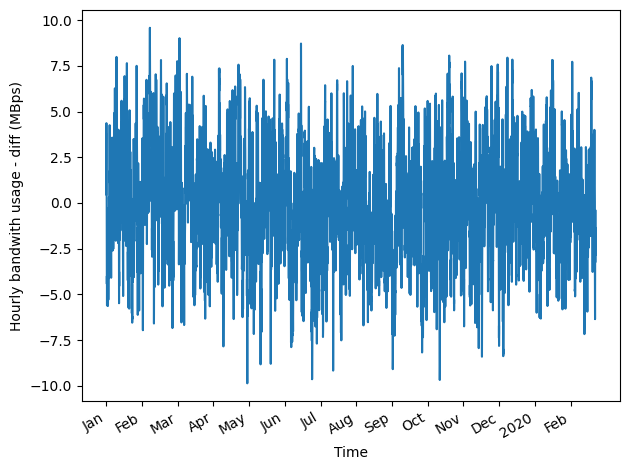

In [106]:
import matplotlib.pyplot as plt

bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [107]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789017
p-value: 0.0


## ACF, PACF그래프

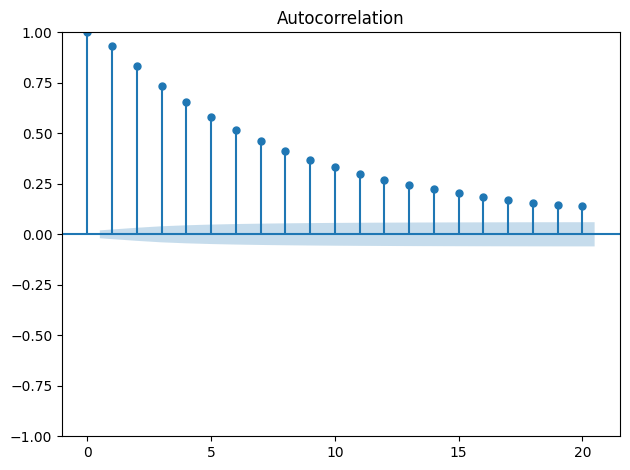

In [108]:
plot_acf(bandwidth_diff, lags=20);
plt.tight_layout()

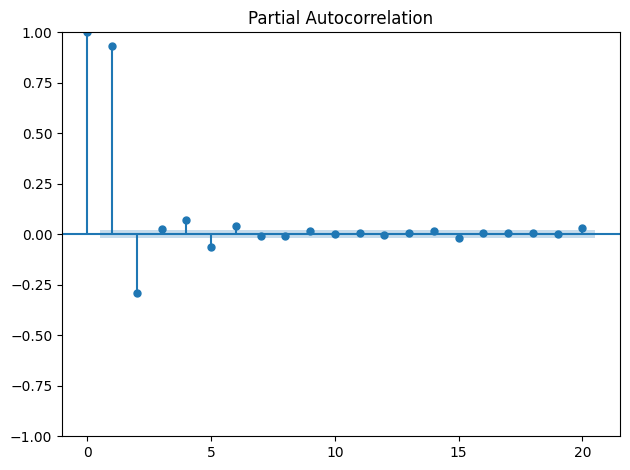

In [109]:
plot_pacf(bandwidth_diff, lags=20);
plt.tight_layout()

## 데이터 분할

In [110]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

#임의로 갯수 선정
train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


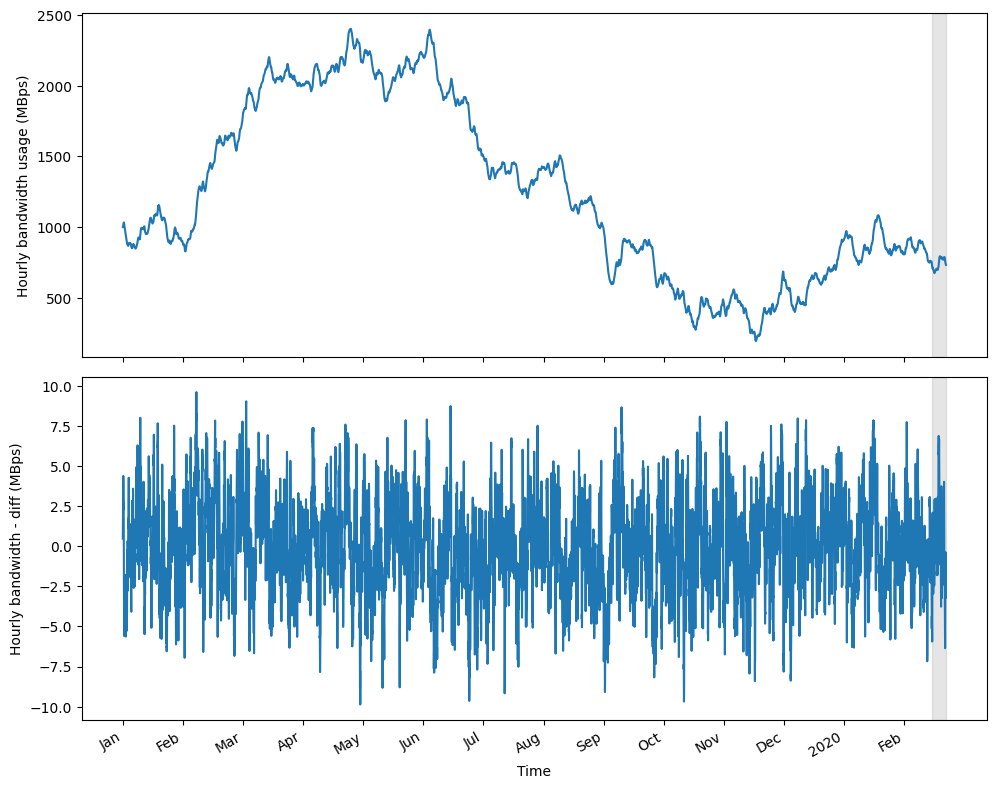

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## ARIMA 모델 피팅

In [112]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

## 잔차 분석

In [ ]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

In [ ]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

# ARIMA - 비정상 시계열

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 단위근 검정
- 차분 2회 지정

# 실전 데이터 적용

In [ ]:
# 향후 2시간의 전기 사용량을 분석하는 데이터

df = pd.read_csv(DATA_PATH + 'bandwidth.csv')
df.head()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### ADF 테스트

- 귀무가설 : 시계열이 비정상적이다.
- 대립가설 : 시계열이 정상적이다.

In [ ]:
ADF_results = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_results[0]}')
print(f'p-value: {ADF_results[1]}')

In [ ]:
ADF_results

- 차분.. 해줘야겠지?

In [ ]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ADF_diff_results = adfuller(bandwidth_diff)

ADF_diff_results

- p값이 0.0인걸 보면 데이터가 정상성을 만족함을 볼 수 있다.

### ACF, PACF그래프

In [ ]:
plot_acf(bandwidth_diff, lags=20);
plt.tight_layout()

In [ ]:
plot_pacf(bandwidth_diff, lags = 20);
plt.tight_layout()

### 데이터 분할

In [ ]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

'''
9831
168
'''

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## ARIMA 모델 피팅

In [ ]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs)) # 가능한 모든 p,q의 조합
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

### 잔차분석 (후속 분석)

In [ ]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

In [ ]:
model_fit.plot_diagnostics(figsize=(10, 8));

### 예측수행
- 롤링 분석 - ARIMA 실행

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

# ARIMA - 비정상 시계열

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 단위근 검정

- 차분 2회 지정

In [ ]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

'''
ADF Statistic: 2.7420165734574744
p-value: 1.0
'''

In [ ]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

'''
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
'''

In [ ]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

'''
ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682
'''

- 차분을 두 번이나 해야 했음

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout

- 차분을 한 게 이정도

## 예측구간 설정

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## 아리마 최적화

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

- 조합 목록 만들기

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2 #차분 - 현재 차분을 2번 했으므로 d는 2로 고정되어야 한다.

order_list = list(product(ps, qs))

In [ ]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

## ARIMA 모델 적용

In [ ]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

## 모델 결과 확인

- 왼쪽 상단 : 시간에 따른 잔차
    - **분산이 일정하지 않음, 백색 소음과 차이 존재**
- 오른쪽 상단 : 잔차의 분포, 정규분포에 가까움
- Q-Q 도식 : 직선적인 선 표시
- 상관관계도 : 지연 3에서 계수가 유의함
- 모델의 오차가 무작위적

In [ ]:
model_fit.plot_diagnostics(figsize=(10,8));

- 정량적 관점 테스트
    - 모두 p값이 0.05보다 큼, 귀무가설 기각하지 않고, 백색소음과 마찬가지로 상관관계 없음

In [ ]:
residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

## 테스트

In [ ]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

In [ ]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

• 파선으로 표시된 ARIMA(3, 2, 3) 모델의 예측이 1980년에 관측된 데이터와 거의 완벽하게 겹치는 것 확인

## 기존 모델과 결과 비교

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

'''
11.561658552433654 1.7102112169997594
'''

In [ ]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()